# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 3, #degree
        'n': 4, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'a_max': 10,
        'a_min': -10,
        'lambda_nets_total': 100,
        'noise': 0,
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
        
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'dropout': 0.25,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
        
        'seed_in_inet_training': False,
              
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 


n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])

config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(inet=True))
create_folders()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [7]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/256 [00:00<?, ?it/s]

List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '13

  0%|          | 0/256 [00:00<?, ?it/s]

List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Load Data and Generate Datasets

In [8]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [9]:
#LOAD DATA
foldername = 'weights_' + str(lambda_nets_total) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:    0.5s finished


## Data Inspection

In [10]:
lambda_net_dataset.as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [11]:
lambda_net_dataset.as_pandas().describe()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

## Generate Datasets for Interpretation-Net training

In [12]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [13]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(81, 1157)

In [14]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(9, 1157)

In [15]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(10, 1157)

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0000-target,0001-target,0002-target,0003-target,0010-target,0011-target,0012-target,0020-target,0021-target,0030-target,0100-target,0101-target,0102-target,0110-target,0111-target,0120-target,0200-target,0201-target,0210-target,0300-target,1000-target,1001-target,1002-target,1010-target,1011-target,1020-target,1100-target,1101-target,1110-target,1200-target,2000-target,2001-target,2010-target,2100-target,3000-target,0000-lstsq_lambda,0001-lstsq_lambda,0002-lstsq_lambda,0003-lstsq_lambda,0010-lstsq_lambda,0011-lstsq_lambda,0012-lstsq_lambda,0020-lstsq_lambda,0021-lstsq_lambda,0030-lstsq_lambda,0100-lstsq_lambda,0101-lstsq_lambda,0102-lstsq_lambda,0110-lstsq_lambda,0111-lstsq_lambda,0120-lstsq_lambda,0200-lstsq_lambda,0201-lstsq_lambda,0210-lstsq_lambda,0300-lstsq_lambda,1000-lstsq_lambda,1001-lstsq_lambda,1002-lstsq_lambda,1010-lstsq_lambda,1011-lstsq_lambda,1020-lstsq_lambda,1100-lstsq_lambda,1101-lstsq_lambda,1110-lstsq_lambda,1200-lstsq_lambda,2000-lstsq_lambda,2001-lstsq_lambda,2010-lstsq_lambda,2100-lstsq_lambda,3000-lstsq_lambda,0000-lstsq_target,0001-lstsq_target,0002-lstsq_target,0003-lstsq_target,0010-lstsq_target,0011-lstsq_target,0012-lstsq_target,0020-lstsq_target,0021-lstsq_target,0030-lstsq_target,0100-lstsq_target,0101-lstsq_target,0102-lstsq_target,0110-lstsq_target,0111-lstsq_target,0120-lstsq_target,0200-lstsq_target,0201-lstsq_target,0210-lstsq_target,0300-lstsq_target,1000-lstsq_target,1001-lstsq_target,1002-lstsq_target,1010-lstsq_target,1011-lstsq_target,1020-lstsq_target,1100-lstsq_target,1101-lstsq_target,1110-lstsq_target,1200-lstsq_target,2000-lstsq_target,2001-lstsq_target,2010-lstsq_target,2100-lstsq_target,3000-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,...,wb_801,wb_802,wb_803,wb_804,wb_805,wb_806,wb_807,wb_808,wb_809,wb_810,wb_811,wb_812,wb_813,wb_814,wb_815,wb_816,wb_817,wb_818,wb_819,wb_820,wb_821,wb_822,wb_823,wb_824,wb_825,wb_826,wb_827,wb_828,wb_829,wb_830,wb_831,wb_832,wb_833,wb_834,wb_835,wb_836,wb_837,wb_838,wb_839,wb_840,wb_841,wb_842,wb_843,wb_844,wb_845,wb_846,wb_847,wb_848,wb_849,wb_850,wb_851,wb_852,wb_853,wb_854,wb_855,wb_856,wb_857,wb_858,wb_859,wb_860,wb_861,wb_862,wb_863,wb_864,wb_865,wb_866,wb_867,wb_868,wb_869,wb_870,wb_871,wb_872,wb_873,wb_874,wb_875,wb_876,wb_877,wb_878,wb_879,wb_880,wb_881,wb_882,wb_883,wb_884,wb_885,wb_886,wb_887,wb_888,wb_889,wb_890,wb_891,wb_892,wb_893,wb_894,wb_895,wb_896,wb_897,wb_898,wb_899,wb_900,wb_901,wb_902,wb_903,wb_904,wb_905,wb_906,wb_907,wb_908,wb_909,wb_910,wb_911,wb_912,wb_913,wb_914,wb_915,wb_916,wb_917,wb_918,wb_919,wb_920,wb_921,wb_922,wb_923,wb_924,wb_925,wb_926,wb_927,wb_928,wb_929,wb_930,wb_931,wb_932,wb_933,wb_934,wb_935,wb_936,wb_937,wb_938,wb_939,wb_940,wb_941,wb_942,wb_943,wb_944,wb_945,wb_946,wb_947,wb_948,wb_949,wb_950,wb_951,wb_952,wb_953,wb_954,wb_955,wb_956,wb_957,wb_958,wb_959,wb_960,wb_961,wb_962,wb_963,wb_964,wb_965,wb_966,wb_967,wb_968,wb_969,wb_970,wb_971,wb_972,wb_973,wb_974,wb_975,wb_976,wb_977,wb_978,wb_979,wb_980,wb_981,wb_982,wb_983,wb_984,wb_985,wb_986,wb_987,wb_988,wb_989,wb_990,wb_991,wb_992,wb_993,wb_994,wb_995,wb_996,wb_997,wb_998,wb_999,wb_1000,wb_1001,wb_

## Interpretation Network Training

[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:   37.6s
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   37.9s remaining:  2.8min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed:   43.2s remaining:  1.3min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   43.6s remaining:   36.3s
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed:   43.7s remaining:   16.4s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   44.4s finished


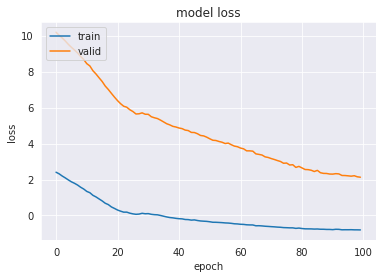

In [19]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                          lambda_net_valid_dataset_list, 
                                                          lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [20]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [21]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [22]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,4.591,5.426,13.653,0.003,0.000,3.067,3.865,1.795,0.561,0.510,1.935,3.221,4.059,3.546,9.515,10.459
inetPoly_VS_targetPoly_test,4.759,5.566,50.564,0.006,0.000,3.756,4.557,2.231,-0.157,0.780,2.747,3.434,1.120,-0.984,11.683,12.923
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,2.913,3.562,1.725,0.620,0.486,1.497,2.851,4.059,3.524,9.515,10.062
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,3.539,4.236,2.157,-0.036,0.739,2.181,3.035,1.120,-0.940,11.683,12.517
inetPoly_VS_lstsqTarget_valid,1.479,1.853,1.032,0.019,0.000,8.254,9.562,1.004,-2.195,1.427,3.281,5.923,4.059,-0.013,9.515,0.241
inetPoly_VS_lstsqTarget_test,1.328,1.655,1.602,0.017,0.000,9.558,10.798,0.989,-3.351,1.776,2.691,5.329,1.120,-0.100,11.683,0.291
inetPoly_VS_lstsqLambda_valid,3.676,5.264,6.331,0.009,0.000,2.893,3.556,1.684,0.622,0.482,1.688,2.841,4.059,3.520,9.515,10.063
inetPoly_VS_lstsqLambda_test,3.481,4.961,101.402,0.023,0.000,3.500,4.187,2.164,-0.019,0.731,2.252,2.988,1.120,-0.939,11.683,12.516
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.307,0.400,0.311,0.997,0.042,0.164,0.399,3.520,3.524,10.063,10.062
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.330,0.426,0.416,0.994,0.055,0.233,0.425,-0.939,-0.940,12.516,12.517


In [23]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9
inetPoly_VS_targetPoly_valid,4.582,3.214,1.702,3.020,2.943,1.874,3.950,1.834,4.486,NaN
inetPoly_VS_targetPoly_test,4.457,3.307,3.403,4.197,7.544,3.334,2.270,1.723,2.701,4.623
inetPoly_VS_predLambda_valid,4.084,2.955,1.583,3.132,2.865,1.653,3.819,1.851,4.276,NaN
inetPoly_VS_predLambda_test,4.471,3.007,3.253,3.718,7.170,2.776,2.181,1.590,2.630,4.588
inetPoly_VS_lstsqTarget_valid,7.618,6.095,4.895,7.549,4.388,12.593,13.544,12.938,4.669,NaN
inetPoly_VS_lstsqTarget_test,10.843,15.344,14.854,10.941,8.790,9.101,2.872,6.861,10.732,5.243
inetPoly_VS_lstsqLambda_valid,4.105,2.940,1.570,3.097,2.843,1.576,3.817,1.813,4.280,NaN
inetPoly_VS_lstsqLambda_test,4.449,2.959,3.183,3.708,7.163,2.693,2.130,1.548,2.597,4.571
lstsqLambda_VS_predLambda_valid,0.399,0.330,0.236,0.325,0.330,0.358,0.206,0.221,0.363,NaN
lstsqLambda_VS_predLambda_test,0.540,0.247,0.414,0.292,0.291,0.415,0.284,0.296,0.276,0.248


In [24]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9
inetPoly_VS_targetPoly_valid,0.503,0.508,0.860,0.528,0.505,0.761,0.495,0.788,0.101,NaN
inetPoly_VS_targetPoly_test,-0.932,0.627,0.647,0.298,-4.099,0.239,0.349,0.892,0.710,-0.304
inetPoly_VS_predLambda_valid,0.647,0.587,0.884,0.536,0.559,0.842,0.529,0.794,0.206,NaN
inetPoly_VS_predLambda_test,-0.965,0.696,0.689,0.501,-3.558,0.511,0.395,0.905,0.729,-0.259
inetPoly_VS_lstsqTarget_valid,-0.130,-0.817,0.015,-1.800,0.005,-5.831,-4.492,-6.626,-0.082,NaN
inetPoly_VS_lstsqTarget_test,-7.835,-5.407,-3.763,-3.029,-5.412,-3.291,-0.033,-0.590,-3.104,-1.048
inetPoly_VS_lstsqLambda_valid,0.644,0.599,0.886,0.547,0.534,0.844,0.530,0.797,0.215,NaN
inetPoly_VS_lstsqLambda_test,-0.918,0.705,0.699,0.504,-3.533,0.530,0.431,0.909,0.737,-0.251
lstsqLambda_VS_predLambda_valid,0.998,0.997,0.998,0.996,0.995,0.994,0.999,0.997,0.996,NaN
lstsqLambda_VS_predLambda_test,0.974,0.999,0.995,0.998,0.996,0.992,0.993,0.997,0.997,0.996


In [25]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-4.09890171103166


<IPython.core.display.Math object>

In [26]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

0.927010615907232


<IPython.core.display.Math object>

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [28]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-0.303873931183692


<IPython.core.display.Math object>

In [29]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9932005212070559


<IPython.core.display.Math object>

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [31]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.15733775580581405 (10 Samples)
Mean (only positive): 0.5373631510431496 (7 Samples)


In [32]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9457845964892899 (10 Samples)
Mean (only positive): 0.9457845964892899 (10 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

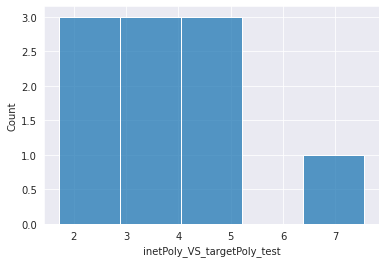

In [33]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

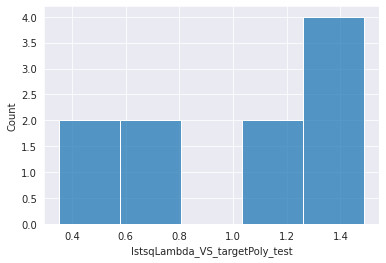

In [34]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30.0, 1.0)]

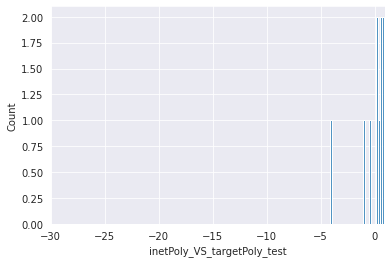

In [35]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

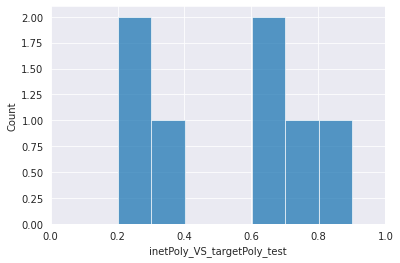

In [36]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

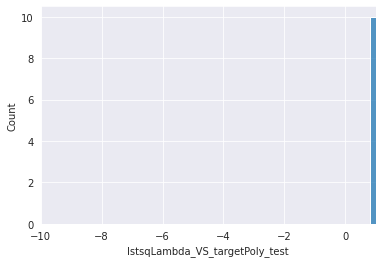

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

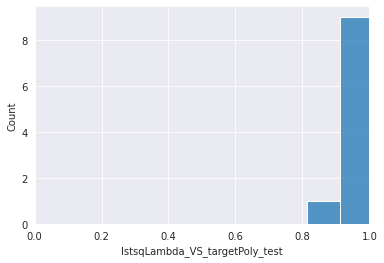

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

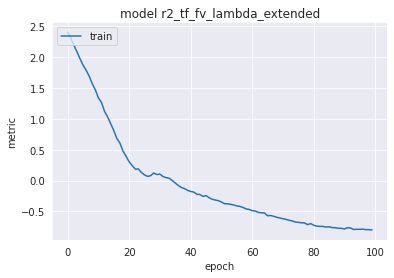

In [39]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


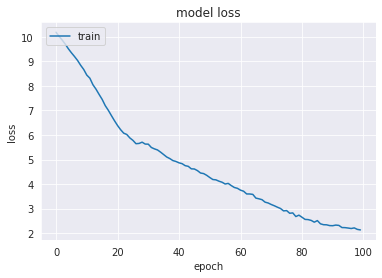

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

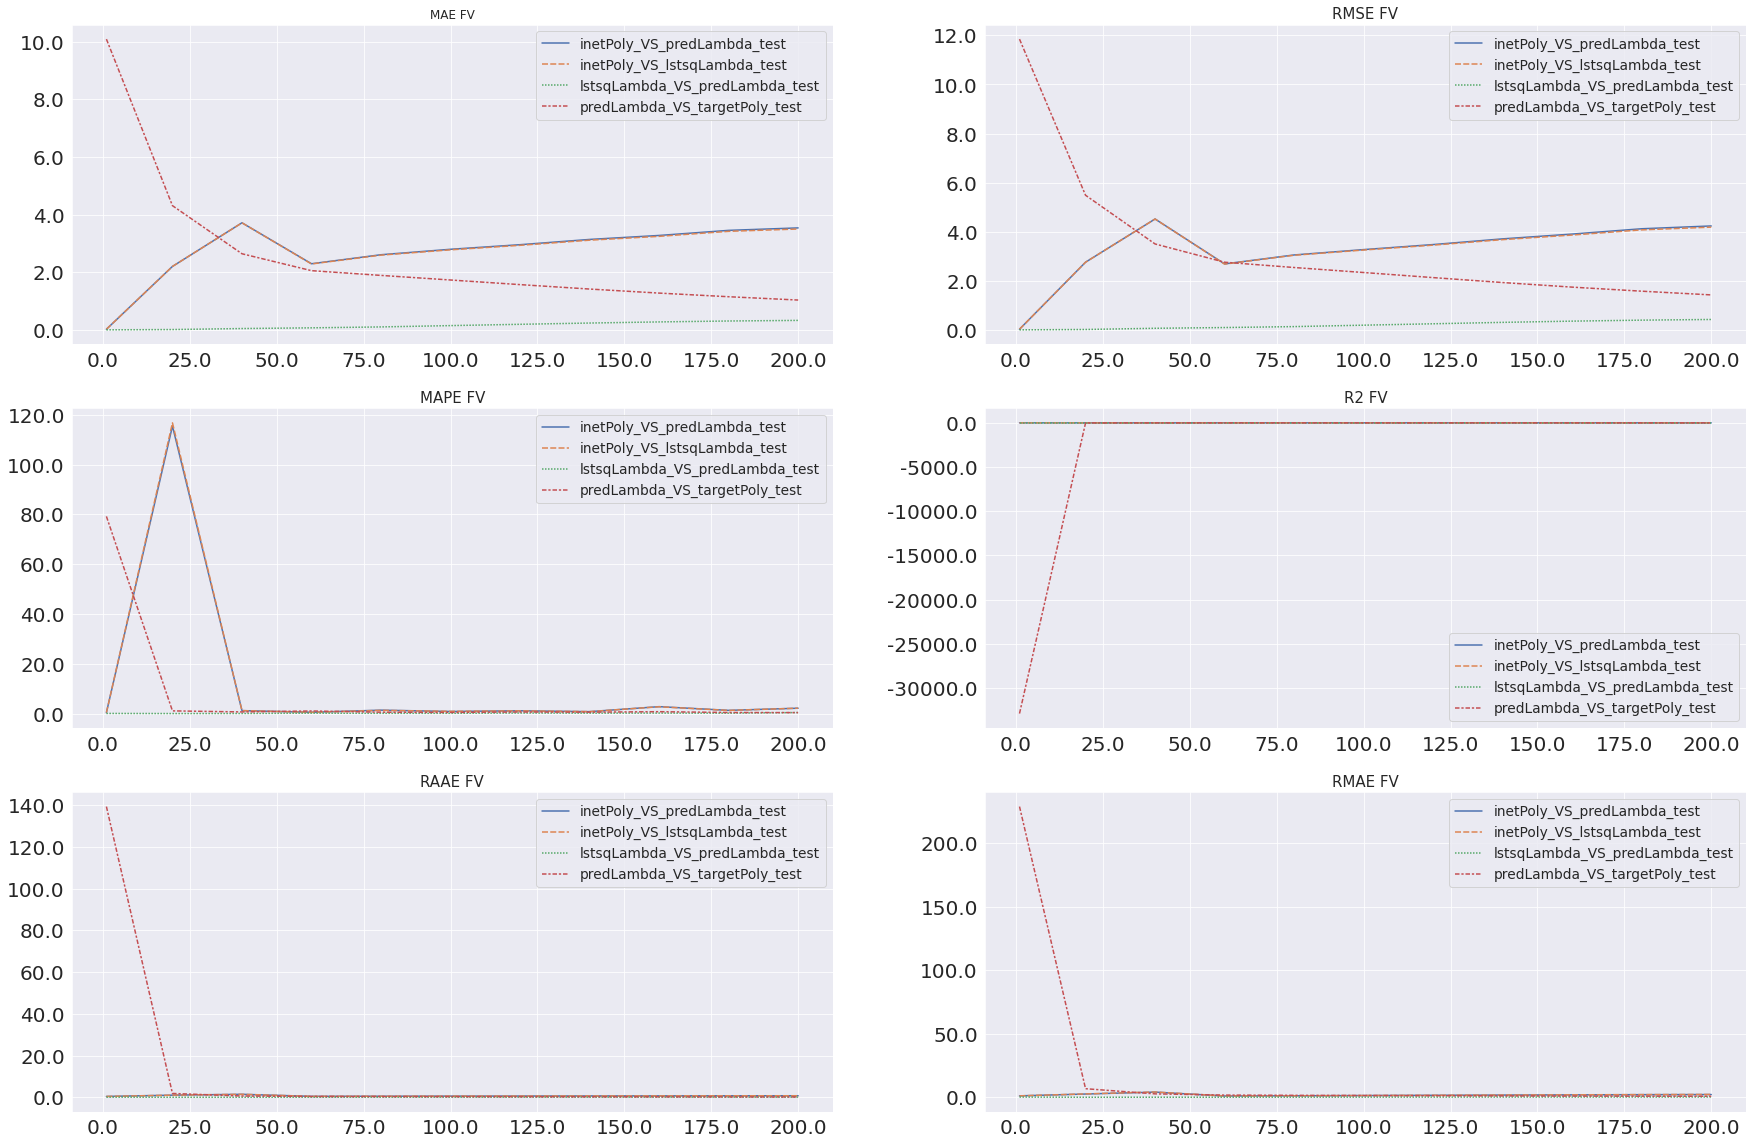

In [41]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

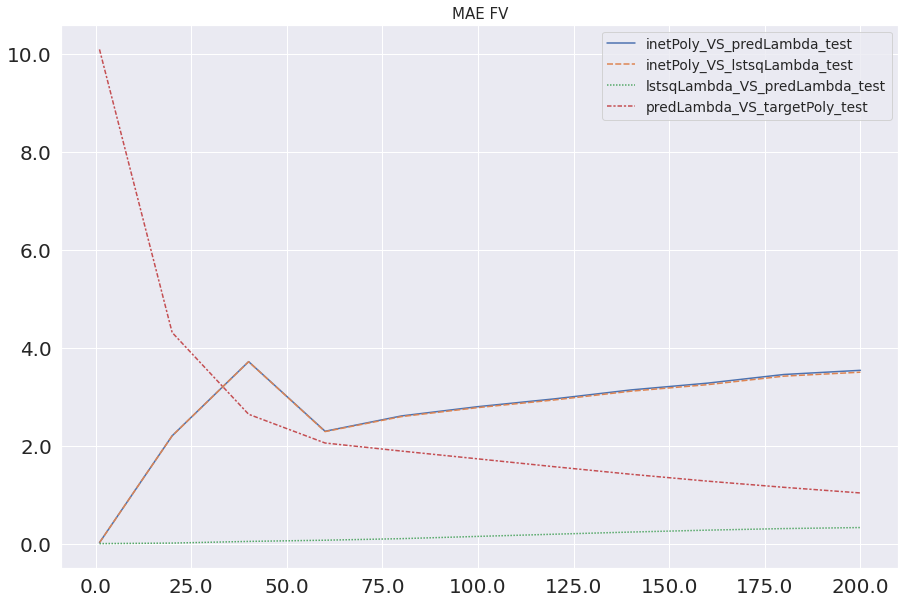

In [42]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

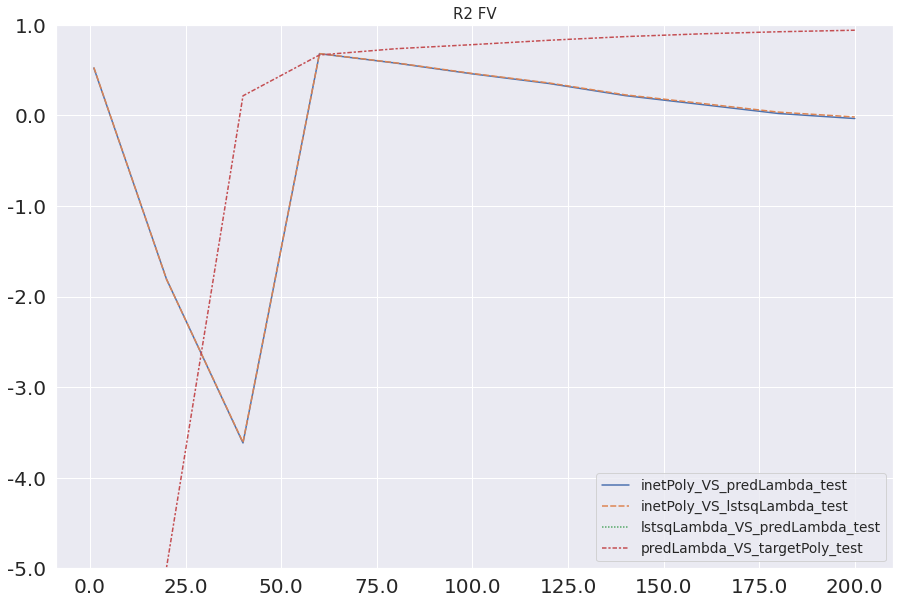

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

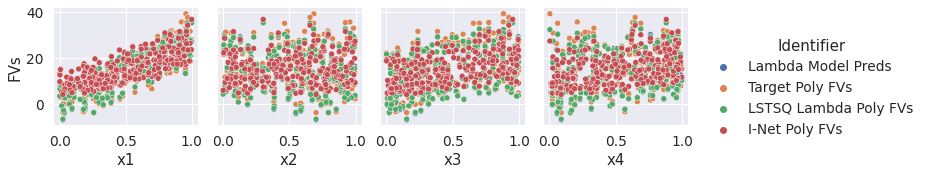

In [44]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=1, 
                                                      plot_type=1)

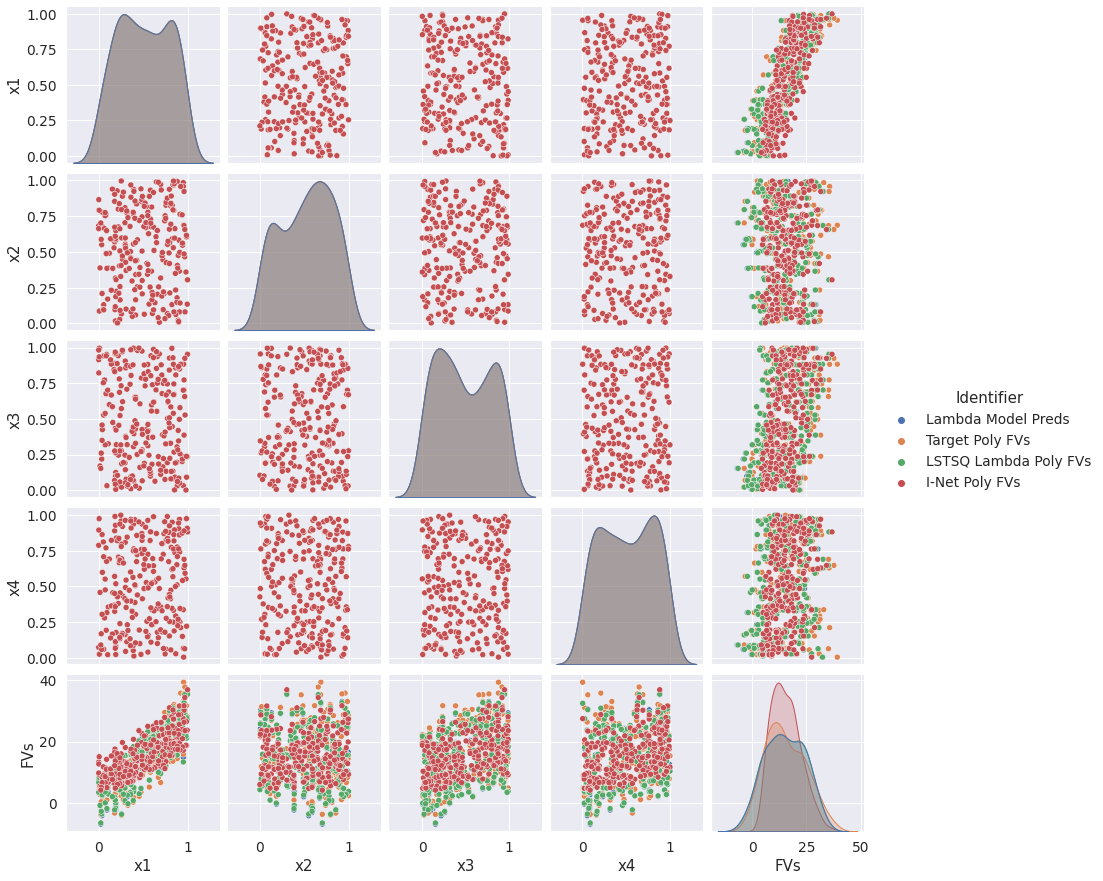

In [45]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=1, 
                                                      plot_type=2)

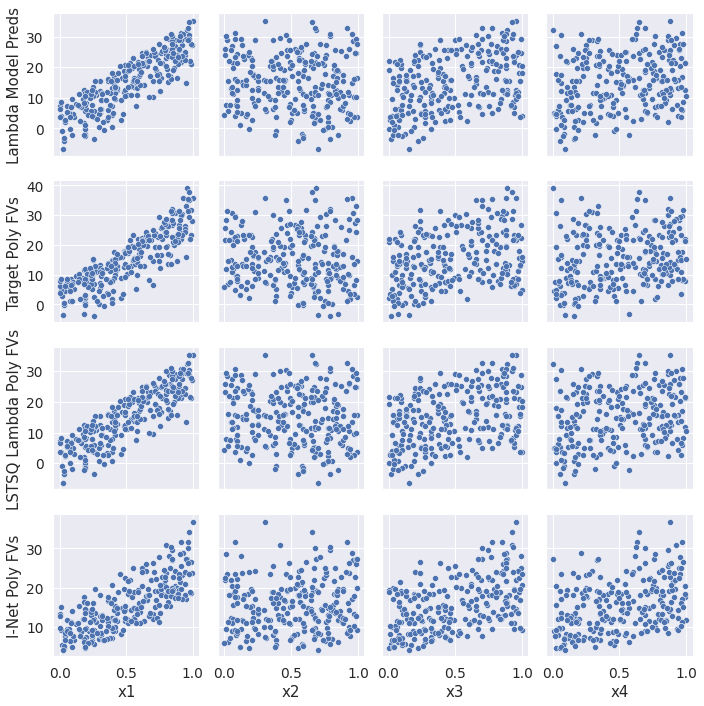

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=1, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [47]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [48]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [49]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 6.4831


In [50]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 14.5732


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [51]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [52]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 10.3283


In [53]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [54]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()